# Section 1 : Environnement

In [ ]:
import numpy as np

class BattleshipGame:
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.reset()

    def reset(self, initialize_ships=None):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)    # 0: empty, 1: hit, 2: ship, -1: miss
        self.grid_visible = np.zeros((self.grid_size, self.grid_size), dtype=int)      # 0: empty, 1: hit, -1: miss   (for the player to see)
        self.number_of_hits = 0
        self.ships = []    # List of ships with their lengths, positions, directions, and states
        self.rdisc = 0     # reward discount
        if initialize_ships is None:
            self.initialize_ships_little()
        else:
            pos = initialize_ships
            if pos < self.grid_size*(self.grid_size-2):
                direction = 'H'
                col = pos // (self.grid_size-2)
                row = pos % (self.grid_size-2)
            else:
                direction = 'V'
                row = (pos - self.grid_size*(self.grid_size-2)) // (self.grid_size-2)
                col = (pos - self.grid_size*(self.grid_size-2)) % (self.grid_size-2)
            self.number_of_hits = 3
            self.add_ship(3, (row, col), direction)

        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))    # this gets updated as an action is performed

        return self.grid_visible    # return the visible board

    def initialize_ships(self):
        ship_definitions = [(2, 1), (3, 1), (4, 1)]     # (length, quantity)
        self.total_hits = 9
        for length, quantity in ship_definitions:
            for _ in range(quantity):
                self.place_ship_randomly(length)

    def initialize_ships_little(self):
        ship_definitions = [(3,1)]     # (length, quantity)
        self.total_hits = 3
        for length, quantity in ship_definitions:
            for _ in range(quantity):
                self.place_ship_randomly(length)

    def display(self):
        symbols = {0: '🌊', 2: '🚢', 1: '💥', -1: '⚪'}

        header = " " + "   ".join(str(i).rjust(3) for i in range(self.grid_size))
        print(header)

        for y in range(self.grid_size):
            row_symbols = [symbols[self.grid[y, x]] for x in range(self.grid_size)]
            row_str = str(y).ljust(3) + ' ' + '   '.join(row_symbols)
            print(row_str)

    def display_visible(self):
        symbols = {0: '🌊', 2: '🚢', 1: '💥', -1: '⚪'}

        header = " " + "   ".join(str(i).rjust(3) for i in range(self.grid_size))
        print(header)

        for y in range(self.grid_size):
            row_symbols = [symbols[self.grid_visible[y, x]] for x in range(self.grid_size)]
            row_str = str(y).ljust(3) + ' ' + '   '.join(row_symbols)
            print(row_str)

    def step(self, action):
        i , j = np.unravel_index(action, (self.grid_size,self.grid_size))

        state = self.grid_visible.copy()

        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)    # board situation before action

        reward = 0
        if (i,j) not in self.legal_actions:
            keep_rndm = True
            while keep_rndm:
                action = np.random.randint(0,self.grid_size*self.grid_size)
                i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
                if (i,j) in self.legal_actions:
                    keep_rndm = False
                reward -= 1 + (1-empty_cnts_pre)/(self.grid_size*self.grid_size)    # penalize for illegal move

        self.set_state(action)   # update the board with the action

        self.set_legal_actions((i,j))

        next_state = self.grid_visible

        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)      # board situation after action

        done = bool(hit_cnts_post == self.total_hits)

        if hit_cnts_post-hit_cnts_pre==1: #hit
            r_discount = 0.5**self.rdisc
            reward += 10*r_discount*hit_cnts_post     # reward for a hit

        reward = float(reward)

        # after a hit, zero the discount, also don't start discounting if first hit hasn't happened yet
        if hit_cnts_post-hit_cnts_pre==1 or hit_cnts_pre==0:
            self.rdisc = 0
        else:
            # we discount the reward for a subsequent hit the longer it takes to score it
            self.rdisc += 1


        return next_state, reward, done

    def update_ships_status(self, action):
        x, y = action
        sunk = False
        for ship in self.ships:
            if not ship['sunk']:
                positions = self.calculate_ship_positions(ship)
                if (x, y) in positions:
                    ship['hits'] += 1
                    if ship['hits'] == ship['length']:
                        ship['sunk'] = True
                        sunk = True
                        break
        return sunk

    def calculate_ship_positions(self, ship):
        x, y = ship['position']
        positions = [(x+i, y) if ship['direction'] == 'H' else (x, y+i) for i in range(ship['length'])]
        return positions

    def check_all_sunk(self):
        return all(ship['sunk'] for ship in self.ships)

    def is_action_valid(self, action):
        x, y = action
        return self.grid[y, x] >= 0

    def place_ship_randomly(self, ship_length):
        placed = False
        while not placed:
            direction = 'H' if np.random.rand() > 0.5 else 'V'
            if direction == 'H':
                x = np.random.randint(0, self.grid_size - ship_length + 1)
                y = np.random.randint(0, self.grid_size)
            else:
                x = np.random.randint(0, self.grid_size)
                y = np.random.randint(0, self.grid_size - ship_length + 1)
            if self.check_free_space(ship_length, (x, y), direction):
                self.add_ship(ship_length, (x, y), direction)
                placed = True

    def check_free_space(self, ship_length, position, direction):
        x, y = position
        if direction.upper() == 'H':
            return all(self.grid[y, x+i] == 0 for i in range(ship_length))
        else:
            return all(self.grid[y+i, x] == 0 for i in range(ship_length))

    def add_ship(self, ship_length, position, direction):
        x, y = position
        if direction == 'H':
            self.grid[y, x:x+ship_length] = 2
        else:
            self.grid[y:y+ship_length, x] = 2
        self.ships.append({'length': ship_length, 'hits': 0, 'position': position, 'direction': direction, 'sunk': False})

    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states == 0]
        hit_cnts = uni_cnts[uni_states == 1]
        miss_cnts = uni_cnts[uni_states == -1]

        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]

        return empty_cnts, hit_cnts, miss_cnts

    def get_legal_actions(self):
        return self.legal_actions

    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)

    def set_state(self, action):
        i , j = np.unravel_index(action, (self.grid_size,self.grid_size))
        if self.grid[i,j]==2:
            self.grid[i,j]= 1
            self.grid_visible[i,j] = 1
        else:
            self.grid[i,j]= -1
            self.grid_visible[i,j] = -1

    def play_episode(self, agent):
        self.reset()
        done = False
        reward = 0
        action = 0
        while not done:
            action = agent.choose_action(action, reward)
            self.number_of_hits += 1
            grid, reward, done = self.step(action)
        return self.number_of_hits

# Section 2 : Simple Agents

In [ ]:
# Agent that chooses random actions

class random_agent():
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
    def choose_action(self, state, hit):
        return np.random.randint(0, self.grid_size**2)

In [ ]:
# Agent that searches for ships and then hunts them until they are sunk and then searches again

class search_and_hunt_agent():
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.is_hunting = False
        self.ship_hunted = []
        self.searched = []

    def choose_action(self, state, reward):
        if not self.is_hunting and reward >0:
            self.is_hunting = True
        if self.is_hunting:
            return self.hunt_ship(state, reward)
        else:
            return self.search_ship(state)

    def search_ship(self, state):
        action = np.random.randint(0, self.grid_size**2)
        while action in self.searched:
            action = np.random.randint(0, self.grid_size**2)
        self.searched.append(action)
        return action

    def hunt_ship(self, state, reward):
        if reward >0:
            self.ship_hunted.append(state)
        for state in self.ship_hunted:
            x, y = state % self.grid_size, state // self.grid_size
            if x > 0 and (state-1) not in self.searched:
                self.searched.append(state-1)
                return state-1
            elif x < self.grid_size-1 and (state+1) not in self.searched:
                self.searched.append(state+1)
                return state+1
            elif y > 0 and (state-self.grid_size) not in self.searched:
                self.searched.append(state-self.grid_size)
                return state-self.grid_size
            elif y < self.grid_size-1 and (state+self.grid_size) not in self.searched:
                self.searched.append(state+self.grid_size)
                return state+self.grid_size
        self.is_hunting = False
        return self.search_ship(state)

In [ ]:
env = BattleshipGame(6)
coup = 0
for i in range(1000):
    agent = search_and_hunt_agent(6)
    coup += env.play_episode(agent)

print(coup/1000)

12.965


# Section 3 : DeepQLearning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple, Deque, Optional, Callable


class Linear_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(Linear_t, self).__init__()
        self.fc = nn.Linear(input_dim, n_action)

    def forward(self, x):
        return self.fc(x)

In [ ]:
class MLP_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(MLP_t, self).__init__()
        self.fc = nn.Linear(input_dim, 124)
        self.fc2 = nn.Linear(124, n_action)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc(x)))

In [ ]:
class CNN_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(CNN_t, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, n_action)

    def forward(self, x):
        x = x.view(-1, 1, 6, 6)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 16 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze()
        return x

In [ ]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: BattleshipGame,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        if np.random.uniform() <= self.epsilon:
            return np.random.randint(0,grid_size*grid_size)
        else:
            state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
            pred_values = self.q_network(state_tensor)
            return np.argmax(pred_values.cpu().detach().numpy())

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
import collections
import random
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [ ]:
num_episodes = 100000

grid_size=6
gamma = 0.95
learning_rate=0.001
momentum=0.9
epsilon=1.0
epsilon_min=0.01
epsilon_decay=(epsilon_min/epsilon)**(1/(0.5*num_episodes))
episode_step = 0.005

env = BattleshipGame(grid_size=grid_size)
model = CNN_t(grid_size*grid_size, grid_size*grid_size)
model_target = CNN_t(grid_size*grid_size, grid_size*grid_size)
q_network_params = model.state_dict()
model_target.load_state_dict(q_network_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.98, min_lr=0.0001)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer(2000)
losses = []
epsilon_greedy = EpsilonGreedy(epsilon_start=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, env=env, q_network=model)
reward_plot = []
epsilon_plot = []
losses_plot = []
counter_plot = []

t1 = 0
iteration = 0
for t in range(num_episodes):

    obs = env.reset()
    if (t) % (episode_step*num_episodes) == 0:
        print('>>>>>>>>>>>>>>>>>>>Episode', t)
        if len(counter_plot)>0:
            print('Avg moves: ', np.mean(np.array(counter_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            print('Avg loss: ', np.mean(np.array(losses_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            t1 += 1

    if t==0:
        epsilon_plot = [0 for i in range(num_episodes)]
        counter_plot = [0 for i in range(num_episodes)]
        reward_plot = [0 for i in range(num_episodes)]
        losses_plot = [0 for i in range(num_episodes)]

    done  = False

    while not done:
        state = env.grid_visible.copy()
        action = epsilon_greedy(state)

        next_state, reward, done = env.step(action)

        replay_buffer.add(state, action, reward, next_state, done)

        if len(replay_buffer) > 32:
            states, actions, rewards, next_states, dones = replay_buffer.sample(32)
            state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
            action_tensor = torch.tensor(action)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)
            next_state_tensor = torch.from_numpy(next_state.astype(np.float32)).flatten()

            with torch.no_grad():
                target = reward_tensor.clone()
                if not done:
                    pred_values_next = model_target(next_state_tensor)
                    target += gamma * torch.max(pred_values_next)

            pred_values = model(state_tensor)
            output = pred_values.clone()
            pred_values[action_tensor] = target
            optimizer.zero_grad()
            loss = loss_fn(output, pred_values)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        try:
            losses_plot[t] += loss.item()
        except:
            continue
        counter_plot[t] += 1
        reward_plot[t] += reward
        epsilon_plot[t] = epsilon_greedy.epsilon

        iteration += 1
        if iteration%100 == 0:
            q_network_params = model.state_dict()

            model_target.load_state_dict(q_network_params)
        if done:
            break

    epsilon_greedy.decay_epsilon()

>>>>>>>>>>>>>>>>>>>Episode 0
>>>>>>>>>>>>>>>>>>>Episode 500
Avg moves:  27.572
Avg loss:  17.805477557873417
>>>>>>>>>>>>>>>>>>>Episode 1000
Avg moves:  28.09
Avg loss:  19.95555965476692
>>>>>>>>>>>>>>>>>>>Episode 1500
Avg moves:  28.052
Avg loss:  21.62699797656876
>>>>>>>>>>>>>>>>>>>Episode 2000
Avg moves:  27.534
Avg loss:  19.617571078245565
>>>>>>>>>>>>>>>>>>>Episode 2500
Avg moves:  27.912
Avg loss:  19.156831208827228
>>>>>>>>>>>>>>>>>>>Episode 3000
Avg moves:  27.434
Avg loss:  20.966443326788372
>>>>>>>>>>>>>>>>>>>Episode 3500
Avg moves:  27.296
Avg loss:  20.92081817729788
>>>>>>>>>>>>>>>>>>>Episode 4000
Avg moves:  27.838
Avg loss:  23.95744379665331
>>>>>>>>>>>>>>>>>>>Episode 4500
Avg moves:  28.058
Avg loss:  22.83441335257003
>>>>>>>>>>>>>>>>>>>Episode 5000
Avg moves:  28.144
Avg loss:  23.387684933698402
>>>>>>>>>>>>>>>>>>>Episode 5500
Avg moves:  27.384
Avg loss:  22.054949691296912
>>>>>>>>>>>>>>>>>>>Episode 6000
Avg moves:  27.672
Avg loss:  25.21321291019715
>>>>>>>

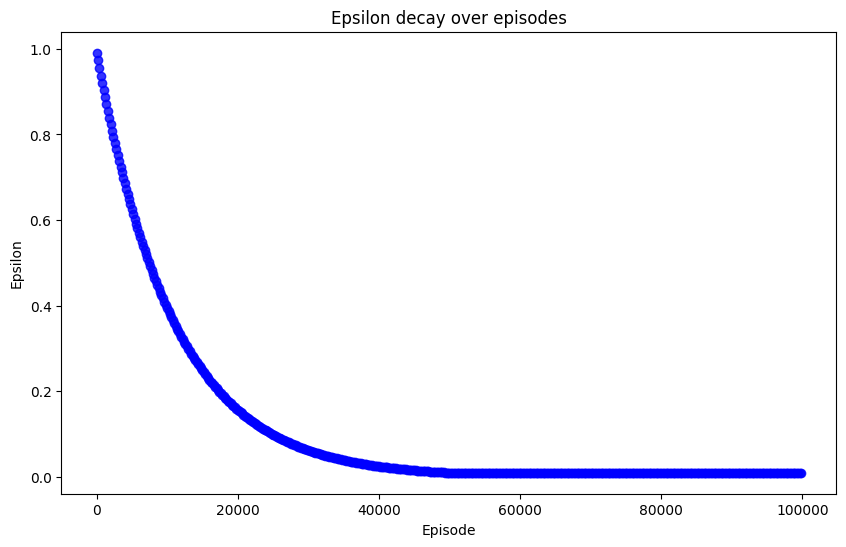

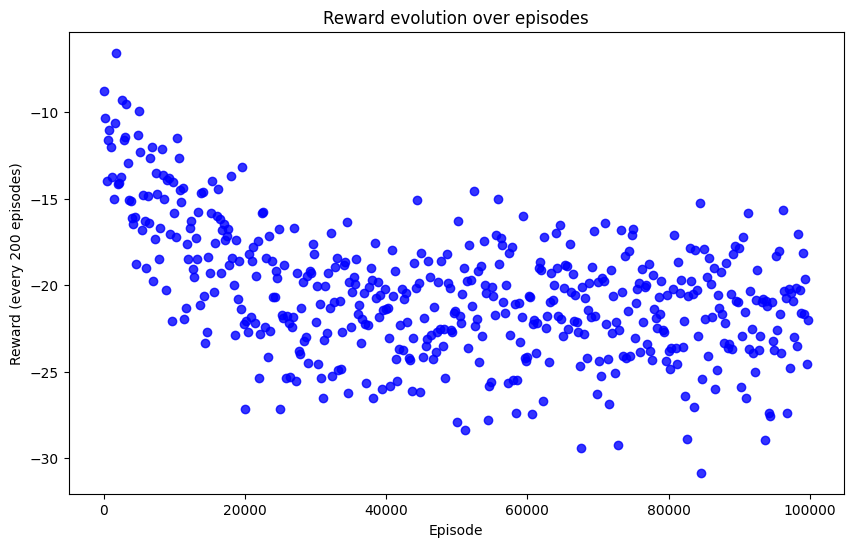

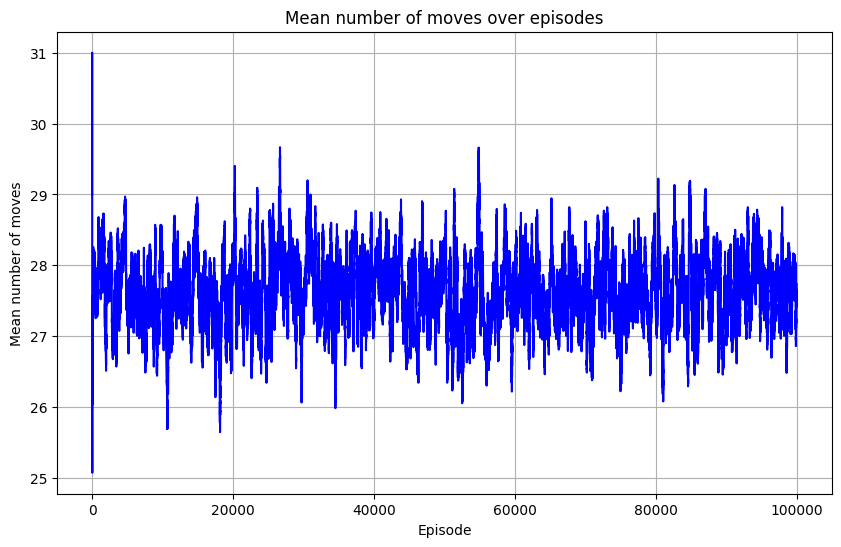

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_episode_step = 200

epsilon_plot_np = np.array(epsilon_plot)
losses_plot_np = np.array(losses_plot)
reward_plot_np = np.array(reward_plot)

episode_range = np.arange(0, num_episodes, num_episode_step)

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(epsilon_plot_np.reshape(-1, num_episode_step), axis=1), color="b", line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon decay over episodes')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(reward_plot_np.reshape(-1, num_episode_step), axis=1), color="b", lowess=True, line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Reward (every {} episodes)'.format(num_episode_step))
plt.title('Reward evolution over episodes')
plt.show()

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.show()


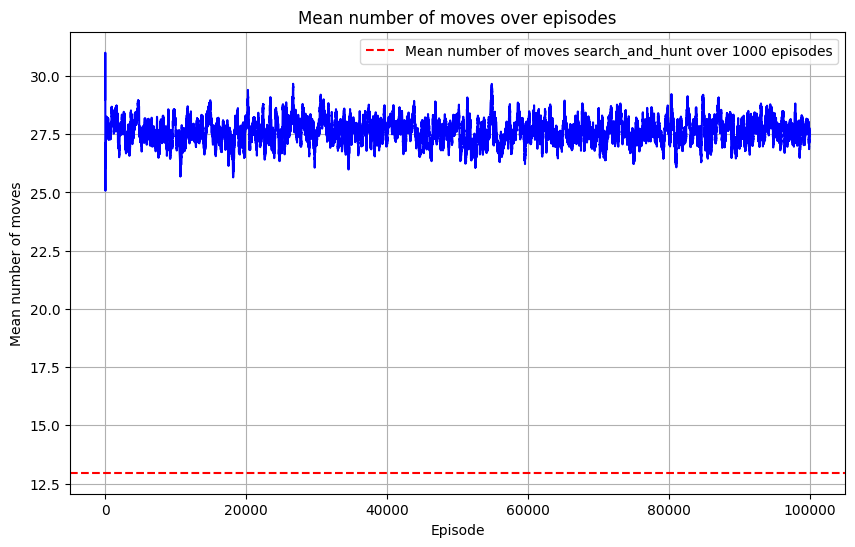

In [ ]:
avg_search_and_hunt = 12.965

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.axhline(y=avg_search_and_hunt, color='r', linestyle='--', label='Mean number of moves search_and_hunt over 1000 episodes')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'find_ship_CNN_6.pth')

In [ ]:
model_loaded = CNN_t(grid_size*grid_size, grid_size*grid_size)
model_loaded.load_state_dict(torch.load('find_ship_CNN_6.pth'))

<All keys matched successfully>

In [ ]:
num_episodes_test = 1000
grid_size=6
env = BattleshipGame(grid_size=grid_size)

mean_hits = 0
for t in range(num_episodes_test):
    obs = env.reset()
    done  = False
    number_of_hits = 0

    while not done:
        state = env.grid_visible.copy()

        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        pred_values = model(state_tensor)
        action = np.nanargmax(pred_values.detach().numpy())

        next_state, reward, done = env.step(action)

        number_of_hits += 1
        if done:
            break

    mean_hits += number_of_hits

#mean number of hits of our agents
print(mean_hits/num_episodes_test)

27.744


In [ ]:
num_episodes_test = 1
grid_size=6
env = BattleshipGame(grid_size=grid_size)

mean_hits = 0
for t in range(num_episodes_test):
    obs = env.reset()
    done  = False
    number_of_hits = 0

    while not done:
        state = env.grid_visible.copy()
        env.display()
        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        pred_values = model(state_tensor)
        action = np.nanargmax(pred_values.detach().numpy())

        next_state, reward, done = env.step(action)

        number_of_hits += 1
        if done:
            break

    mean_hits += number_of_hits

# example of a game
print(mean_hits/num_episodes_test)

   0     1     2     3     4     5
0   🌊   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊   🚢
2   🌊   🌊   🌊   🌊   🌊   🚢
3   🌊   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🌊   🌊
5   🌊   🌊   🌊   🌊   🌊   🌊
   0     1     2     3     4     5
0   🌊   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊   🚢
2   🌊   🌊   ⚪   🌊   🌊   🚢
3   🌊   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🌊   🌊
5   🌊   🌊   🌊   🌊   🌊   🌊
   0     1     2     3     4     5
0   🌊   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊   🚢
2   🌊   🌊   ⚪   🌊   🌊   🚢
3   🌊   🌊   🌊   🌊   🌊   🚢
4   ⚪   🌊   🌊   🌊   🌊   🌊
5   🌊   🌊   🌊   🌊   🌊   🌊
   0     1     2     3     4     5
0   🌊   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊   🚢
2   🌊   🌊   ⚪   🌊   🌊   🚢
3   🌊   🌊   🌊   🌊   🌊   🚢
4   ⚪   🌊   🌊   🌊   🌊   🌊
5   🌊   🌊   ⚪   🌊   🌊   🌊
   0     1     2     3     4     5
0   🌊   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊   🚢
2   🌊   🌊   ⚪   🌊   🌊   🚢
3   🌊   🌊   🌊   ⚪   🌊   🚢
4   ⚪   🌊   🌊   🌊   🌊   🌊
5   🌊   🌊   ⚪   🌊   🌊   🌊
   0     1     2     3     4     5
0   🌊   🌊 